In [90]:
import csv
import math
import numpy as np
from transformations import euler_from_quaternion
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import statsmodels.formula.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [91]:
f = open('combined_data.csv')
csv_f = csv.reader(f)

x_actual_dists = []
y_angles = []
z_vars = []

In [92]:
class Labels(object):
    pred_dist = 0
    tag_transx = 1
    tag_transy = 2
    tag_transz = 3
    tag_rotx = 4
    tag_roty = 5
    tag_rotz = 6
    tag_rotw = 7
    home_transx = 8
    home_transy = 9
    home_transz = 10
    home_rotx = 11
    home_roty = 12
    home_rotz = 13
    home_rotw = 14

In [93]:
#n = 0 
current_predicted_dists = []
current_measured_dists = []
current_measured_angs = []

for row in csv_f:
    if len(row) == 0 or row[0] == "" or row[0] == "\x1a":
#        print ("NEW LINE")

        # ANALYZE SEGMENT
        if len(current_predicted_dists) > 0:
            # calculate avg of measured dists and angles
            avg_measured_dist = sum(current_measured_dists)/len(current_measured_dists)
            avg_measured_ang = sum(current_measured_angs)/len(current_measured_angs)
            x_actual_dists.append(avg_measured_dist)
            y_angles.append(avg_measured_ang)
            
            # calculate variance
            var = np.var(current_predicted_dists)
            z_vars.append(var)
       
            # reset
            current_predicted_dists = []
            current_measured_dists = []
            current_measured_angs = []

    elif row[0] == "predicted distance":
#        print ("HEADING")
        continue
    
    else:
#        print (row)
        # add predicted distance
#        print (row[Labels.pred_dist])
        current_predicted_dists.append(float(row[Labels.pred_dist]))
#        print (current_predicted_dists)
        # add measured distance
        x1, y1, z1 = float(row[Labels.tag_transx]), \
                     float(row[Labels.tag_transy]), \
                     float(row[Labels.tag_transz])
        x2, y2, z2 = float(row[Labels.home_transx]), \
                     float(row[Labels.home_transy]), \
                     float(row[Labels.home_transz])

        dist = math.sqrt(math.pow(x1-x2, 2) + math.pow(y1-y2, 2) \
             + math.pow(z1-z2, 2))
#        print (dist)
        current_measured_dists.append(dist)
        
        angle_tag = euler_from_quaternion([row[Labels.tag_rotx],
                                      row[Labels.tag_roty],
                                      row[Labels.tag_rotz],
                                      row[Labels.tag_rotw]], axes="sxyz")
        angle_home = euler_from_quaternion([row[Labels.home_rotx],
                                      row[Labels.home_roty],
                                      row[Labels.home_rotz],
                                      row[Labels.home_rotw]], axes="sxyz")
        a1 = angle_tag[2]
        a2 = angle_home[2]
        if a1 < 0:
            a1 += math.pi
        if a2 < 0:
            a2 += math.pi
        angle = abs(a2-a1)
        if angle > math.pi/2:
            angle = math.pi - angle
#        if angle < 0:
#            angle += math.pi
        current_measured_angs.append(angle)

In [94]:
f.close()


In [95]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('Distance (m)')
ax.set_ylabel('Angle (rad)')
ax.set_zlabel('Variance')

ax.scatter(x_actual_dists, y_angles, z_vars)

In [96]:
#flights = flights.pivot(x_actual_dists, y_angles, z_vars)
#ax = sns.heatmap(flights)
datapts = pd.read_csv('rectangle.csv')
#datapts.head()

couple_columns = datapts[['actual dist','angle', 'var']]
couple_columns.head()

x_y = couple_columns.groupby(['actual dist', 'angle']).mean()
x_y.head(20)

var
actual dist angle            
0.25-0.5    0.0-0.2  0.001788
            0.2-0.4  0.001858
            0.4-0.6  0.001890
            0.6-0.8  0.001911
            0.8-1.0  0.001322
            1.0-1.2  0.001158
            1.2-1.4  0.001708
            1.4-1.6  0.001550
0.5-0.75    0.0-0.2  0.001797
            0.2-0.4  0.001371
            0.4-0.6  0.001192
            0.6-0.8  0.001099
            0.8-1.0  0.001085
            1.0-1.2  0.001147
            1.2-1.4  0.001078
            1.4-1.6  0.000813
0.75-1.0    0.0-0.2  0.001364
            0.2-0.4  0.001506
            0.4-0.6  0.001554
            0.6-0.8  0.001388

In [100]:
x_y.pivot('actual dist', 'angle')['var'].head()

angle,0.0-0.2,0.2-0.4,0.4-0.6,0.6-0.8,0.8-1.0,1.0-1.2,1.2-1.4,1.4-1.6
actual dist,,,,,,,,
0.25-0.5,0.001788,0.001858,0.001890,0.001911,0.001322,0.001158,0.001708,0.001550
0.5-0.75,0.001797,0.001371,0.001192,0.001099,0.001085,0.001147,0.001078,0.000813
0.75-1.0,0.001364,0.001506,0.001554,0.001388,0.000921,0.000968,0.000955,0.001065
1.0-1.25,0.000904,0.000783,0.000952,0.000762,0.001006,0.000740,0.000880,0.000756
1.25-1.5,0.000866,0.000679,0.000872,0.000893,0.000835,0.000967,0.000845,0.000809


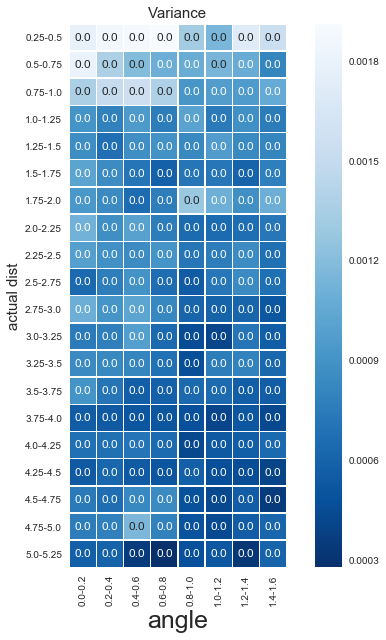

In [112]:
plt.figure(figsize=(10,10))
pivot_table = x_y.pivot('actual dist', 'angle', 'var')
plt.xlabel('Distance Ranges (m)', size=25)
plt.ylabel('Angle Ranges (rad)', size=15)
plt.title('Variance', size=15)
sns.heatmap(pivot_table, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Blues_r');
sns.plt.show()

In [99]:
data = pd.DataFrame({"X": x_actual_dists, "Y": y_angles, "Z": z_vars})
result = sm.ols(formula="Z ~ np.power(X, .0005) + np.power(Y, .05)", data=data).fit()

print (result.params)
print (result.summary())

Intercept             0.695856
np.power(X, .0005)   -0.693439
np.power(Y, .05)     -0.001371
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                      Z   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     305.3
Date:                Fri, 30 Jun 2017   Prob (F-statistic):          4.48e-117
Time:                        02:18:21   Log-Likelihood:                 13229.
No. Observations:                2099   AIC:                        -2.645e+04
Df Residuals:                    2096   BIC:                        -2.643e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------